<a href="https://colab.research.google.com/github/Kushal94gitgit/Research-project/blob/main/inversecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Kushal cell1
# Imports


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib, json

fwd_model = keras.models.load_model(
    "bandgap_mlp_keras.h5",
    compile=False
)

scaler_X = joblib.load("scaler_X.pkl")

with open("feature_names.json", "r") as f:
    feature_names = json.load(f)

n_features = len(feature_names)


In [6]:
#Kushal cell2
#train false

fwd_model.trainable = False


In [7]:
#Kushal cell3
#Layers

def build_inverse_nn(n_features):
    inp = keras.Input(shape=(1,))
    x = layers.Dense(64, activation="relu")(inp)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    out = layers.Dense(n_features, activation="linear")(x)
    return keras.Model(inp, out)

inv_model = build_inverse_nn(n_features)


In [8]:
#Kushal cell4
#Model Building


target_bg = keras.Input(shape=(1,))

# wrap inverse model
x_scaled = keras.layers.Lambda(
    lambda x: inv_model(x),
    name="inv_wrapper"
)(target_bg)

# project 17 -> 24
x_scaled = keras.layers.Dense(24, name="projection_17_to_24")(x_scaled)

# wrap forward model
bg_pred = keras.layers.Lambda(
    lambda x: fwd_model(x),
    name="fwd_wrapper"
)(x_scaled)

inverse_pipeline = keras.Model(
    inputs=target_bg,
    outputs=bg_pred,
    name="inverse_pipeline"
)

inverse_pipeline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse"
)


In [9]:
#Kushal cell5
#Loss evaluation

target_bandgaps = np.linspace(0.5, 5.5, 200).reshape(-1, 1)

inverse_pipeline.fit(
    target_bandgaps,
    target_bandgaps,
    epochs=300,
    batch_size=32,
    verbose=2
)


Epoch 1/300
7/7 - 1s - 187ms/step - loss: 6.5529
Epoch 2/300
7/7 - 0s - 30ms/step - loss: 6.1964
Epoch 3/300
7/7 - 0s - 9ms/step - loss: 5.5664
Epoch 4/300
7/7 - 0s - 9ms/step - loss: 5.0054
Epoch 5/300
7/7 - 0s - 9ms/step - loss: 4.0637
Epoch 6/300
7/7 - 0s - 9ms/step - loss: 3.1992
Epoch 7/300
7/7 - 0s - 10ms/step - loss: 2.2280
Epoch 8/300
7/7 - 0s - 9ms/step - loss: 1.4500
Epoch 9/300
7/7 - 0s - 9ms/step - loss: 1.0937
Epoch 10/300
7/7 - 0s - 8ms/step - loss: 0.5838
Epoch 11/300
7/7 - 0s - 20ms/step - loss: 0.4687
Epoch 12/300
7/7 - 0s - 8ms/step - loss: 0.3670
Epoch 13/300
7/7 - 0s - 9ms/step - loss: 0.3053
Epoch 14/300
7/7 - 0s - 9ms/step - loss: 0.3750
Epoch 15/300
7/7 - 0s - 9ms/step - loss: 0.3219
Epoch 16/300
7/7 - 0s - 10ms/step - loss: 0.3631
Epoch 17/300
7/7 - 0s - 9ms/step - loss: 0.3165
Epoch 18/300
7/7 - 0s - 9ms/step - loss: 0.3029
Epoch 19/300
7/7 - 0s - 9ms/step - loss: 0.2459
Epoch 20/300
7/7 - 0s - 10ms/step - loss: 0.2763
Epoch 21/300
7/7 - 0s - 9ms/step - loss: 0

In [10]:
#Kushal cell5
#Scaling

target_bg = keras.Input(shape=(1,))

x_scaled_17 = inv_model(target_bg)   # ← REQUIRED

projection = keras.layers.Dense(24, name="projection_17_to_24")
x_scaled_24 = projection(x_scaled_17)


In [11]:
#Kushal cell6
#Projection

# define once
projection = keras.layers.Dense(24, name="projection_17_to_24")

# use everywhere
x_scaled_24 = projection(x_scaled_17)


In [12]:
#Kushal cell6
#Pulling Request

bg_request = np.array([[2.0]])  # desired bandgap in eV

# inverse model output (17)
x_scaled_17 = inv_model.predict(bg_request)

# project 17 -> 24 (use the SAME Dense layer weights if trained, or define once)
projection = keras.layers.Dense(24)
x_scaled_24 = projection(x_scaled_17)

# now inverse scale
x_pred = scaler_X.inverse_transform(x_scaled_24)

for name, val in zip(feature_names, x_pred[0]):
    print(name, val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Sr.No. 25.41783117131773
material_id 22.712427475964073
formula_pretty 2.694494320732277
band_gap 4.450711350882347
energy_above_hull 1.5223371429019044
formation_energy_per_atom 0.04586873567117749
predicted_formation_energy_per_atom -1.388999098666887
density 0.09298360743298692
volume 6.9102982527262675
nsites 86.447792851458
Elements 7.540718355009033
lattice_a 84.65176352654963
lattice_b 10.377305820079163
lattice_c 84.74068945431421
lattice_alpha 49.55081249895476
lattice_beta 47.702077339811886
lattice_gamma 8.863378488910406


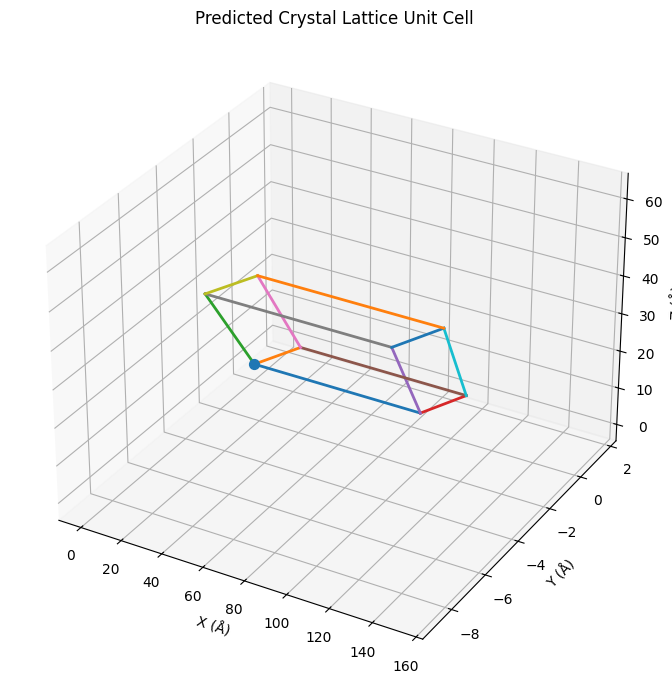

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract lattice parameters
a = x_pred[0][feature_names.index("lattice_a")]
b = x_pred[0][feature_names.index("lattice_b")]
c = x_pred[0][feature_names.index("lattice_c")]

alpha = np.deg2rad(x_pred[0][feature_names.index("lattice_alpha")])
beta  = np.deg2rad(x_pred[0][feature_names.index("lattice_beta")])
gamma = np.deg2rad(x_pred[0][feature_names.index("lattice_gamma")])

# Lattice vectors (crystallography convention)
v1 = np.array([a, 0, 0])

v2 = np.array([
    b * np.cos(gamma),
    b * np.sin(gamma),
    0
])

v3 = np.array([
    c * np.cos(beta),
    c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma),
    c * np.sqrt(
        1
        - np.cos(alpha)**2
        - np.cos(beta)**2
        - np.cos(gamma)**2
        + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
    ) / np.sin(gamma)
])

# Origin
O = np.zeros(3)

# Corners of the unit cell
points = [
    O,
    v1,
    v2,
    v3,
    v1 + v2,
    v1 + v3,
    v2 + v3,
    v1 + v2 + v3
]

# Edges of the unit cell
edges = [
    (0,1),(0,2),(0,3),
    (1,4),(1,5),
    (2,4),(2,6),
    (3,5),(3,6),
    (4,7),(5,7),(6,7)
]

# Plot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for i, j in edges:
    ax.plot(
        [points[i][0], points[j][0]],
        [points[i][1], points[j][1]],
        [points[i][2], points[j][2]],
        linewidth=2
    )

# Labels
ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Predicted Crystal Lattice Unit Cell")

ax.scatter(0, 0, 0, s=50)  # origin
plt.tight_layout()
plt.show()
